<a href="https://colab.research.google.com/github/khondokarsumaya/210101__CNN_with_FMNIST/blob/main/210101___CNN_with_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [98]:
!git clone https://github.com/khondokarsumaya/210101__CNN_with_FMNIST.git


fatal: destination path '210101__CNN_with_FMNIST' already exists and is not an empty directory.


In [99]:
import shutil
import os

# Define the directory name
directory_to_remove = '210101__CNN_with_FMNIST'

# Check if the directory exists and remove it
if os.path.exists(directory_to_remove):
    shutil.rmtree(directory_to_remove)
    print(f"Removed existing directory: {directory_to_remove}")
else:
    print(f"Directory {directory_to_remove} does not exist.")

Removed existing directory: 210101__CNN_with_FMNIST


In [100]:
!git clone https://github.com/khondokarsumaya/210101__CNN_with_FMNIST.git

Cloning into '210101__CNN_with_FMNIST'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 35 (delta 11), reused 18 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 345.40 KiB | 4.43 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [101]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



In [102]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


In [103]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [104]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(model)


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [106]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [107]:
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [108]:
epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # ----------- Training -----------
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ----------- Validation -----------
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    # ----------- Accuracy Calculation -----------
    train_acc = calculate_accuracy(train_loader, model)
    val_acc = calculate_accuracy(test_loader, model)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/10], Train Loss: 0.6171, Val Loss: 0.3951, Train Acc: 0.8611, Val Acc: 0.8536
Epoch [2/10], Train Loss: 0.4116, Val Loss: 0.3460, Train Acc: 0.8853, Val Acc: 0.8722
Epoch [3/10], Train Loss: 0.3562, Val Loss: 0.3240, Train Acc: 0.8934, Val Acc: 0.8784
Epoch [4/10], Train Loss: 0.3247, Val Loss: 0.3044, Train Acc: 0.9013, Val Acc: 0.8876
Epoch [5/10], Train Loss: 0.3008, Val Loss: 0.2791, Train Acc: 0.9154, Val Acc: 0.8988
Epoch [6/10], Train Loss: 0.2816, Val Loss: 0.2708, Train Acc: 0.9181, Val Acc: 0.9027
Epoch [7/10], Train Loss: 0.2648, Val Loss: 0.2596, Train Acc: 0.9257, Val Acc: 0.9073
Epoch [8/10], Train Loss: 0.2508, Val Loss: 0.2637, Train Acc: 0.9258, Val Acc: 0.9042
Epoch [9/10], Train Loss: 0.2383, Val Loss: 0.2594, Train Acc: 0.9317, Val Acc: 0.9055
Epoch [10/10], Train Loss: 0.2280, Val Loss: 0.2458, Train Acc: 0.9388, Val Acc: 0.9112


In [109]:
torch.save(model.state_dict(), "210101.pth")
print("✅ Model Saved as 210101.pth")


✅ Model Saved as 210101.pth


In [110]:

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]


In [111]:
model.load_state_dict(torch.load("210101.pth", map_location=device))
model.eval()


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [112]:
def predict_image(img_path):
    image = Image.open(img_path)
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)
        pred_class = torch.argmax(probabilities).item()
        confidence = probabilities[0][pred_class].item() * 100
    return pred_class, confidence


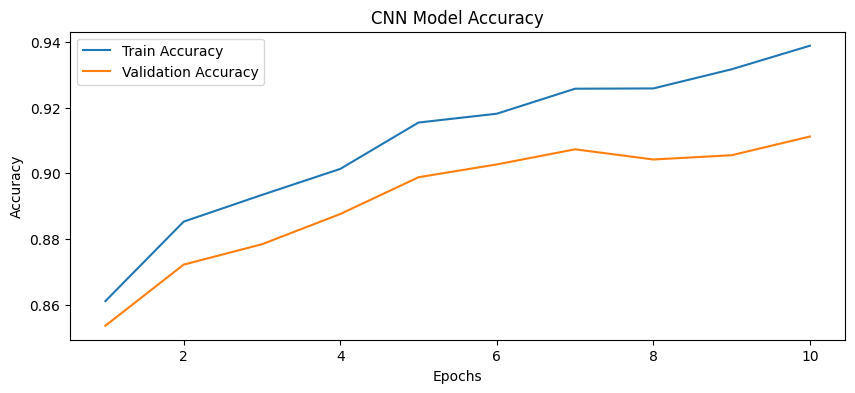

In [113]:
plt.figure(figsize=(10,4))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')
plt.legend()
plt.show()


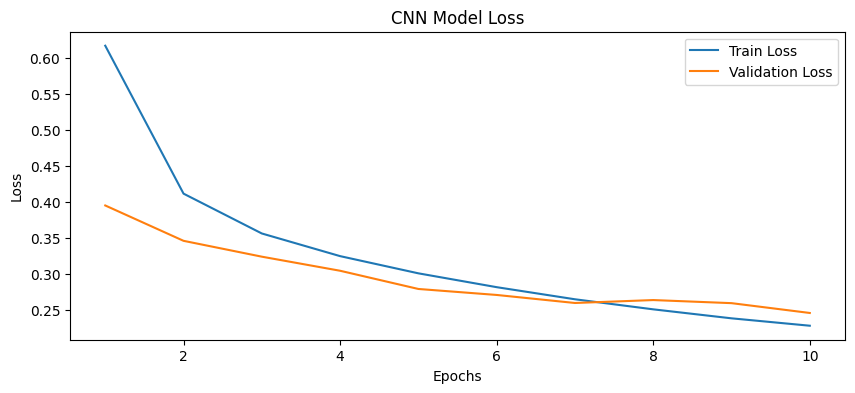

In [114]:
plt.figure(figsize=(10,4))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')
plt.legend()
plt.show()


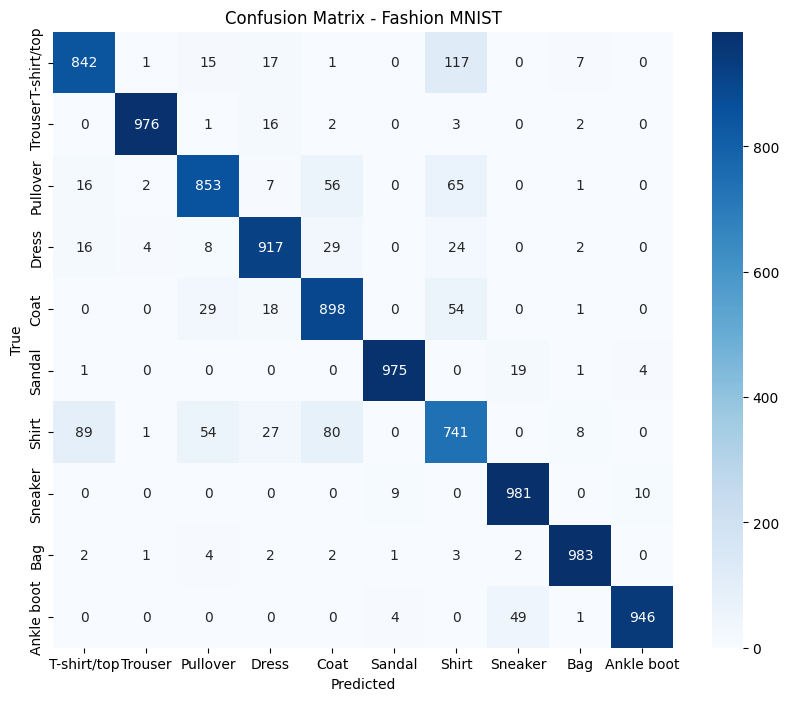

In [115]:
# Predictions on Test Set
y_pred_list = []
y_true_list = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true_list, y_pred_list)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fashion MNIST')
plt.show()


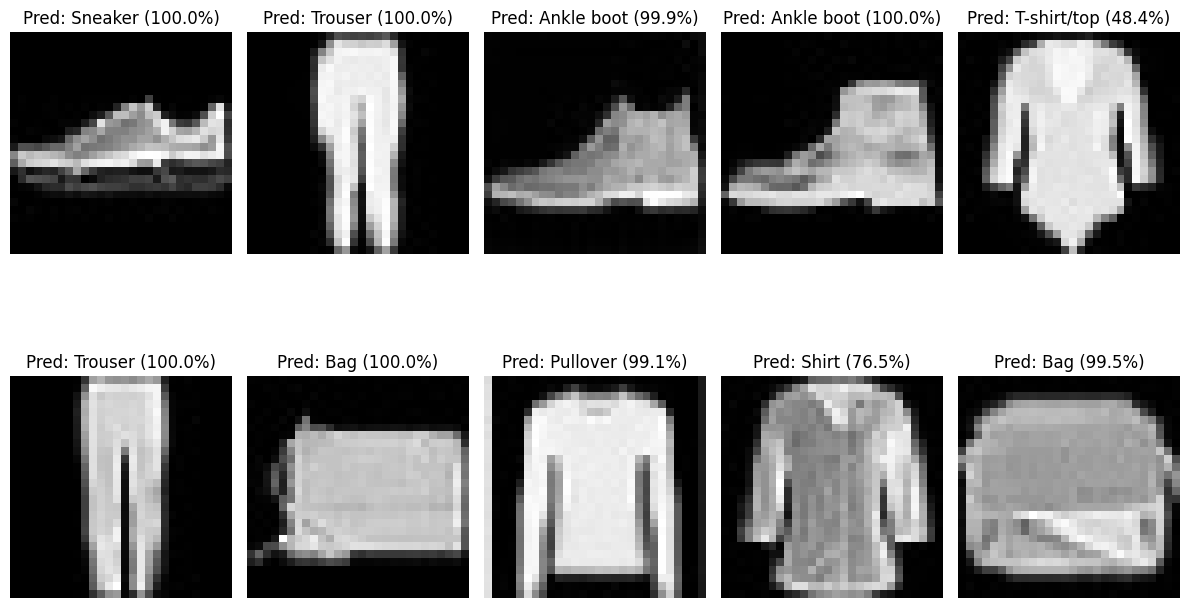

In [116]:
custom_path = "210101__CNN_with_FMNIST/dataset"
images = os.listdir(custom_path)

plt.figure(figsize=(12, 8))

for i, img_name in enumerate(images[:10]):
    img_path = os.path.join(custom_path, img_name)
    pred, conf = predict_image(img_path)
    img = Image.open(img_path).convert("L")

    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {class_names[pred]} ({conf:.1f}%)")
    plt.axis('off')

plt.tight_layout()
plt.show()


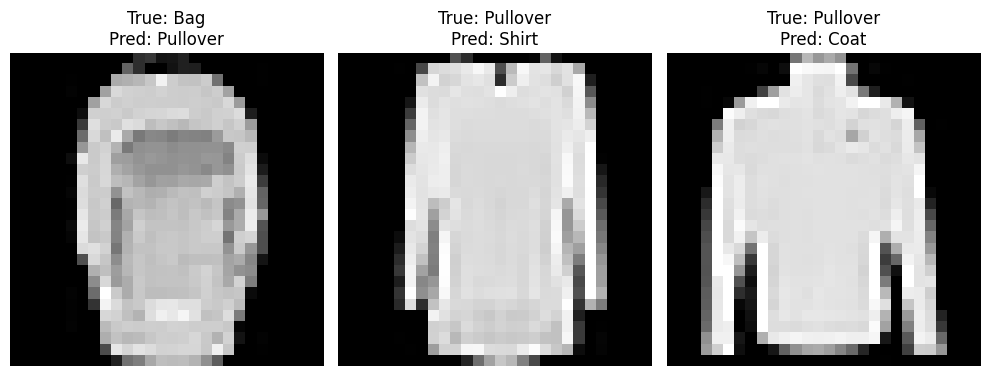

In [117]:
wrong_indices = [i for i, (t, p) in enumerate(zip(y_true_list, y_pred_list)) if t != p]
sample_indices = random.sample(wrong_indices, 3)

plt.figure(figsize=(10,4))
for i, idx in enumerate(sample_indices):
    img, label = test_dataset[idx]
    plt.subplot(1, 3, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"True: {class_names[y_true_list[idx]]}\nPred: {class_names[y_pred_list[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
